# Fractal Dimension and Box Counting Functions for Calculating the Fractal Dimension of Data Elevation Maps (DEM) of Antarctic Terrain

Professor Volodymyr Kindratenko

Ezra Hazique bin Mohamad Mahazir, ehm5, CS397 SU24

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
from scipy.stats import linregress as lr
from PIL import Image

# Box Counting Function

The function estimates how "rough" or "complex" a terrain surface is using a 3D box-counting method. Firstly, it divides the 2D terrain into square blocks of size box_size $\times$ box_size. Then check subsets of the box of terrain and use the mask to ignore invalid values. Then compute the height in each box. Then we use the following formula to count the boxes in the region:

$\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:Box\:Count = \frac{height}{box\:size}$

The height is the height we calculated earlier by subtracting the maximum elevation by the minimum elevation in the region. Thus this simulates covering the 3D terrain with cubes of side length box_size. Then we keep a running sum of all the vertical boxes across the entire terrain and return this value.

In [2]:
def box_count(raster, mask, box_size):
    rows, cols = raster.shape
    total_count = 0

    for i in range(0, rows, box_size):
        for j in range(0, cols, box_size):
            end_row = min(i + box_size, rows)
            end_col = min(j + box_size, cols)

            current_slice = raster[i:end_row, j:end_col]
            current_mask = mask[i:end_row, j:end_col]

            valid_vals = current_slice[~current_mask]
            if valid_vals.size > 0:
                max_val = np.max(valid_vals)
                min_val = np.min(valid_vals)
                hdiff = max_val - min_val
                box_count = mt.ceil(hdiff / box_size)
                total_count += box_count

    return total_count

# Fractal Dimension Function

This functions loads a terrain elevation file (.tif DEM) and computes it fractal dimension of the terrrain surface using the box-counting method. It also visualizes the terrain and the log-log plot used for calculations. First, it opens the .tif image and converts it into a NumPy 2D array (raster). Then a mask is created to ignore invalid elevation values. According to the FRIDGE Antartic 2m DEM database, no data is represented by the value -9999 which is what we will mask out of our data.

Then we print raster information which are the shape, dimension, min, mean and max. These help verify that the data loaded correctly. Then, display the elevation data as a grayscale image where lighter areas correspond to higher elevation values and darker ones to lower elevations. Next, for each box size, it calls the box_count() function to get the number of vertical 3D boxes needed to cover the terrain and store the result in counts.

Once all counts are collected, the function transforms the data using logarithms for linear regression. In the formulae, $\epsilon$ represents box size and $N(\epsilon)$ represents the number of boxes counted. Below are the formulae used:

X-Axis: $\:\:\:\:\:\:\:\:\:\:\:\log{(\frac{1}{\epsilon})}$

Y-Axis: $\:\:\:\:\:\:\:\:\:\:\:\log{N(\epsilon)}$

A linear regression is then performed on this log-log data to estimate the relationship between box size and box count. According to the theory of fractals, the relationship follows a power law:

$\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: N(\epsilon) \propto \epsilon^{-D}$

$\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: \log{}{N(\epsilon)} = D \log{}{(\frac{1}{\epsilon})} + C $

Here, D is the fractal dimension of the terrain, and C is a constant. Thus, the slope of the line from the regression gives the estimated fractal dimension. Finally, the function plots the log-log data and the fitted line to visually confirm the power-law behavior, prints the resulting fractal dimension, and returns it. A slope near 2.0 indicates a surface that’s almost planar, higher slopes indicate more complexity (slope > 2.0). In short:

$Slope \approx 2.0 $: Nearly planar terrain

$Slope > 2.0$: Increasing complexity/roughness terrain

$Slope \to 3.0$: Highly convoluted and space‐filling terrain

In [6]:
def fractal_dimension(tif_file, box_sizes):
    Image.MAX_IMAGE_PIXELS = None
    image = Image.open(tif_file)
    raster = np.array(image)
    mask = (raster == -9999)

    print(f"'{tif_file}' has shape {raster.shape} with {raster.ndim}D dimensions")

    avg = np.mean(raster[~mask])
    low = np.min(raster[~mask])
    high = np.max(raster[~mask])

    df = pd.DataFrame({"Average Elevation": [avg], "Minimum Elevation": [low], "Maximum Elevation": [high]})
    print(df)

    # plt.imshow(raster, cmap='gray')
    # plt.colorbar(label='Elevation')
    # plt.title('Elevation Data')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.show()

    counts = []
    bsize = []
    for box_size in box_sizes:
        bsize.append(box_size)
        count = box_count(raster, mask, box_size)
        counts.append(count)
    
    df_counts = pd.DataFrame({"Box Size": bsize, "Counted Boxes": counts})
    print(df_counts)

    log_eps = np.log(1 / np.array(box_sizes))
    log_counts = np.log(counts)

    slope, intercept, *_ = lr(log_eps, log_counts)

    plt.figure(figsize=(8, 6))
    plt.plot(log_eps, log_counts, 'o', label='Log-Log Data')
    plt.plot(log_eps, slope * log_eps + intercept, 'r', label=f'Fit: slope = {slope:.4f}')
    plt.xlabel('log(1/ε)')
    plt.ylabel('log(N(ε))')
    plt.title('Fractal Dimension Estimation')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Estimated fractal dimension: {slope:.4f}")
    return slope

# Testing the Function with a Random Antarctic Terrain DEM

'SETSM_s2s041_WV03_20240328_1040010092555600_1040010094CC8500_2m_seg1_dem.tif' has shape (11990, 9759) with 2D dimensions
   Average Elevation  Minimum Elevation  Maximum Elevation
0         508.074554           73.28125             1097.0
    Box Size  Counted Boxes
0          5        3573089
1         10         934256
2         15         419634
3         20         236801
4         25         151687
5         30         105392
6         35          77468
7         40          59197
8         45          46765
9         50          37798
10        55          31249
11        60          26213
12        65          22270
13        70          19230
14        75          16699
15        80          14653
16        85          13012
17        90          11566
18        95          10376
19       100           9354


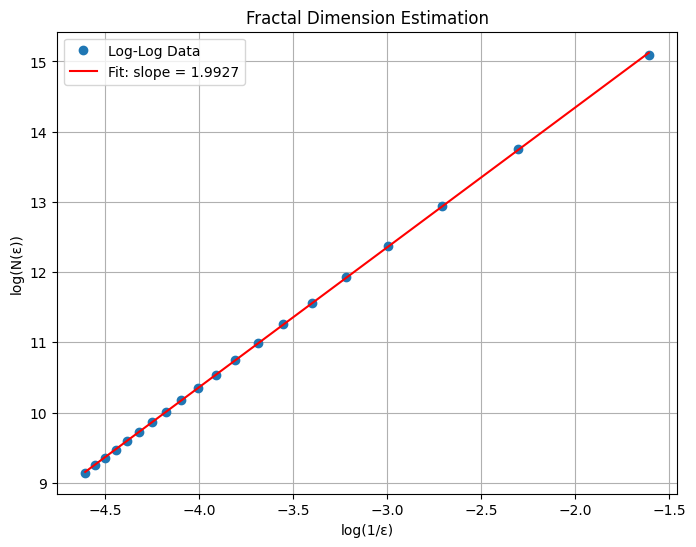

Estimated fractal dimension: 1.9927


In [12]:
box_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000]
list_of_box_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
test_tif = "SETSM_s2s041_WV03_20240328_1040010092555600_1040010094CC8500_2m_seg1_dem.tif"
test_fd = fractal_dimension(test_tif, list_of_box_sizes)

The log–log plot is linear, and the fitted slope of about 1.969 lies just under 2.0. Since a perfectly flat plane would give a value of 2.0, this result tells us that, at the 10 – 2000 pixel scales used, this patch of Antarctic terrain is overwhelmingly planar, with only a small amount of roughness (from crevasses, melt channels, or surface undulations). While there is measurable complexity beyond a pure plane, the ice surface behaves almost like a smooth surface at these resolutions, and any fractal detail contributes only a modest “bump” above the ideal 2.0 baseline.